In [405]:
import configparser
from pathlib import Path
import pandas as pd
import pandas.io.sql as pandasql
from psycopg2 import connect
import numpy
from psycopg2.extras import execute_values
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from setuptools import setup, find_packages
from itertools import islice 
import matplotlib.patches as patches
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
from itertools import combinations, chain
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [160]:
merged = pd.read_sql('''select * from congestion.merged_segments_v2 where length >200
''',con)

## Greedy forward partitioning

In [161]:
def handle_subsection(subsection, prev_i, max_segment_length=250.):
    # Scans through each subsection of `lengths`, grouping together
    # segments up to `max_segment_length`.
    subsec_segments = [{'idx': [prev_i, ], 'length': subsection[0]}]

    if len(subsection) > 1:
        for i, item in enumerate(subsection[1:]):
            if subsec_segments[-1]['length'] + item < max_segment_length or (i== 0 and subsec_segments[0]['length'] < 100):
                subsec_segments[-1]['idx'].append(i + prev_i + 1)
                subsec_segments[-1]['length'] += item
            elif subsec_segments[-1]['length'] + item > max_segment_length:
                subsec_segments.append({'idx': [i + prev_i + 1, ], 'length': item})
    return subsec_segments

In [ ]:
# forward partition
max_multi_length = 250.
min_segment_length = 100.
for index, row in merged.iterrows():
    segment_id = merged['segment_id'].iloc[index].astype(float)
    lengths = merged['length_set'].iloc[index]
    link_dir = merged['link_set'].iloc[index]    
    segments = []
    segments.extend(handle_subsection(lengths, 0))
    segments = sorted(segments, key=lambda x: x['idx'][0])
    too_small = [i for i in range(len(segments)) if segments[i]['length'] < 100]
    n_deleted = 0

    for ir in too_small:
        i = ir - n_deleted
        if i == 0:
            segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
            segments[1]['length'] += segments[i]['length']
        elif i == len(segments) - 1:
            segments[-2]['idx'] += segments[i]['idx']
            segments[-2]['length'] += segments[i]['length']
        else:
            if segments[i - 1]['length'] >= segments[i + 1]['length']:
                segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
                segments[i + 1]['length'] += segments[i]['length']
            else:
                segments[i - 1]['idx'] += segments[i]['idx']
                segments[i - 1]['length'] += segments[i]['length']
        del segments[i]
        n_deleted += 1
    rows = []
    for i in range(len(segments)):
        id = i
        new_length = segments[i]['length']
        link_set = []
        for i in segments[i]['idx']:
            link_set.append(link_dir[i])
        row = (segment_id, id, link_set, new_length)
        rows.append(row) 
    sql = '''insert into congestion.test_pythonmerge_probs(segment_id, id, link_set, length) VALUES %s'''    
    with con:
        with con.cursor() as cur:
            execute_values(cur, sql, rows)

## Best Group

In [496]:
small_groups = pd.read_sql('''with sets as (
                                select * from congestion.merged_segments_v2 inner join 
                                (select distinct segment_id from congestion.partition_result)long
                                using (segment_id))

                                select * from sets
                                where array_length(length_set, 1) <9 and array_length(length_set,1)>2
                                ''',con)

In [497]:
rows = []
for index, row in small_groups.iterrows():
    row = []
    length_set = small_groups['length_set'].iloc[index]
    link_dir = small_groups['link_set'].iloc[index] 
    segment_id = small_groups['segment_id'].iloc[index].astype(float)
    length = small_groups['length'].iloc[index].astype(float)
    
    # Get number of dividing groups based on length and number of links
    num_link, groups = get_num_groups(length_set, length)
    
    # Return divided group set
    return_groups, group_set = return_results(length_set, groups)
    # Make selection based on summed length
    selection = evaluate_results(return_groups)
    
    # Retrieve selected partitioned array
    result_link, result_length = find_link(group_set, selection)
    
    # Prepare rows for sql inserting
    for i in range(len(result_link)):
        new_link_set = result_link[i]
        new_length = sum(result_length[i]) 
        new_length_set = result_length[i]
        row = (segment_id, i, new_link_set, new_length_set, new_length)
        rows.append(row)

sql = '''insert into congestion.partition_all_possibility(segment_id, id, link_set, length_set, length) VALUES %s'''    
with con:
    with con.cursor() as cur:
        execute_values(cur, sql, rows)     

In [475]:
def get_num_groups(length_set, length):
    num_link = len(length_set)
    long_link = 0
    for i in length_set:
        if i >200:
            long_link = long_link + 1
    groups = 1+ int(length/200) + long_link
    return num_link, groups

In [476]:
def split_list(data, n):
    for splits in combinations(range(1, len(data)), n-1):
        result = []
        prev = None
        for split in chain(splits, [None]):
            result.append(data[prev:split])
            prev = split
        yield result

In [493]:
def return_results(length_set, groups):
    possibility = []
    for i in range(1, groups+1):
        split_result = split_list(length_set, i)
        for a in split_result:  
            possibility.append(a)           
    group_result = []
    group_set = []
    for groups in possibility:
        result = []
        sets = []
        for set in groups:
            sum_length = sum(set)
            result.append(sum_length)
            sets.append(set)
        group_result.append(result) 
        group_set.append(sets)
    return group_result, group_set

In [478]:
def evaluate_results(return_groups):
    set_result = []
    for set in return_groups:
        sum_diff = 0
        for i in range(len(set)):
            diff = abs(200-set[i])
            sum_diff = sum_diff + diff
        set_result.append(sum_diff)  
    selection = set_result.index(min(set_result))
    return selection

In [479]:
def find_link(group_set, selection):
    length_to_split = []
    for i in group_set[selection]:
         length_to_split.append(len(i))

    Input = iter(link_dir) 
    split_link = [list(islice(Input, elem)) 
              for elem in length_to_split] 
    return split_link, group_set[selection]

In [ ]:
# potential function for using the same partitioning for groups that are the "same" (e.g. same link length just different directions)
def check_repeated_groups(start_vid, end_vid, length_set):
    

## Simulated annealing

## Validating

Text(0, 0.5, 'Number of segments')

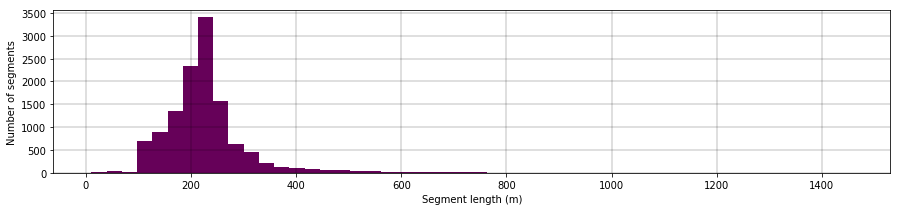

In [164]:
class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''select segment_id, length from (
select segment_id from congestion.merged_segments_v2
except
select distinct segment_id from congestion.partition_result)a
inner join congestion.merged_segments_v2 using (segment_id)
union all
select segment_id, length from congestion.partition_result''',con)
plt.figure(figsize=(15,3))
plt.hist(duration_freq.length, bins=50, color = colour.purple)
axes = plt.gca()
axes.set_facecolor('xkcd:white')
axes.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')

## Best group partitioning

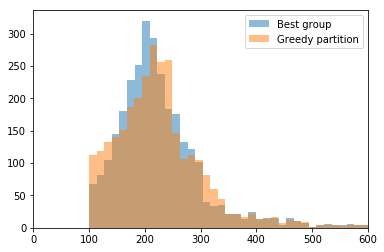

In [519]:
from matplotlib import pyplot
duration_freq1 = pd.read_sql('''select partition_result.* from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_all_possibility)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select * from congestion.partition_all_possibility''',con)
pyplot.hist(duration_freq.length, 100, alpha=0.5, label='Best group')
pyplot.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy partition')
pyplot.xlim(0, 600)
pyplot.legend(loc='upper right')
pyplot.show()